**PACKAGES**
> 
We will first import the packages nessary to develop and run our models

In [128]:
# Basic data manipulation 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O 

# Data processing packages
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score

# Random Forest packages
from sklearn.ensemble import RandomForestClassifier

# Boosting packages
from sklearn.ensemble import GradientBoostingClassifier

# Data visulaisation
import matplotlib.pyplot as plt
import seaborn as sns

**IMPORTING DATA**
> 
We can now begin to import our data from the csv files

In [129]:
DATA_PATH = "../input/playground-series-s3e16/"

# Read data in from files
train_data = pd.read_csv(DATA_PATH + "train.csv") # Importing training data set
test_data  = pd.read_csv(DATA_PATH + "test.csv") # Importing test data set

train_data.head()

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9
1,1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8
2,2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9
3,3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11
4,4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8


**DATA SUMMARY**

- We will first look at a summary of the data pressent. 
- We can see the the ID column is mearly an idenifing key and thus we can remove it as it provides no infomation about our target
- We can also see that Sex is catagorical so this will have to be one-hot-encoded later.

In [130]:
# summary table function
def summary(df):
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values 
    summ['%missing'] = df.isnull().sum().values / len(df)* 100
    summ['#unique'] = df.nunique().values
    
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['first value'] = df.loc[0].values
    summ['second value'] = df.loc[1].values
    summ['third value'] = df.loc[2].values
    
    print(f'data shape: {df.shape}')
    return summ

def process_data(df):
    df = df.drop("id", axis=1)
    return df

train_data = process_data(train_data)

In [131]:
summary(train_data)

data shape: (74051, 9)


,data type,#missing,%missing,#unique,min,max,first value,second value,third value
Sex,object,0,0.0,3,NaN,NaN,I,I,M
Length,float64,0,0.0,144,0.1875,2.012815,1.525,1.1,1.3875
Diameter,float64,0,0.0,122,0.1375,1.6125,1.175,0.825,1.1125
Height,float64,0,0.0,65,0.0,2.825,0.375,0.275,0.375
Weight,float64,0,0.0,3096,0.056699,80.101512,28.973189,10.418441,24.777463
Shucked Weight,float64,0,0.0,1766,0.028349,42.184056,12.728926,4.521745,11.3398
Viscera Weight,float64,0,0.0,967,0.042524,21.54562,6.647958,2.324659,5.556502
Shell Weight,float64,0,0.0,1048,0.042524,28.491248,8.348928,3.40194,6.662133
Age,int64,0,0.0,28,1.0,29.0,9,8,9


**EXPLORATORY ANALYSIS OF INPUT FEATURES**

- We can look at the data to check what the data types and format of the data is. 
- We know that we are aiming to predict the age column
- We have 8 numerical features 
- We have 1 catagorical feature

In [132]:
# select numerical and categorical variables respectively.
num_cols = train_data.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_cols = train_data.select_dtypes(include=['object']).columns.tolist()
num_cols.remove('Age')

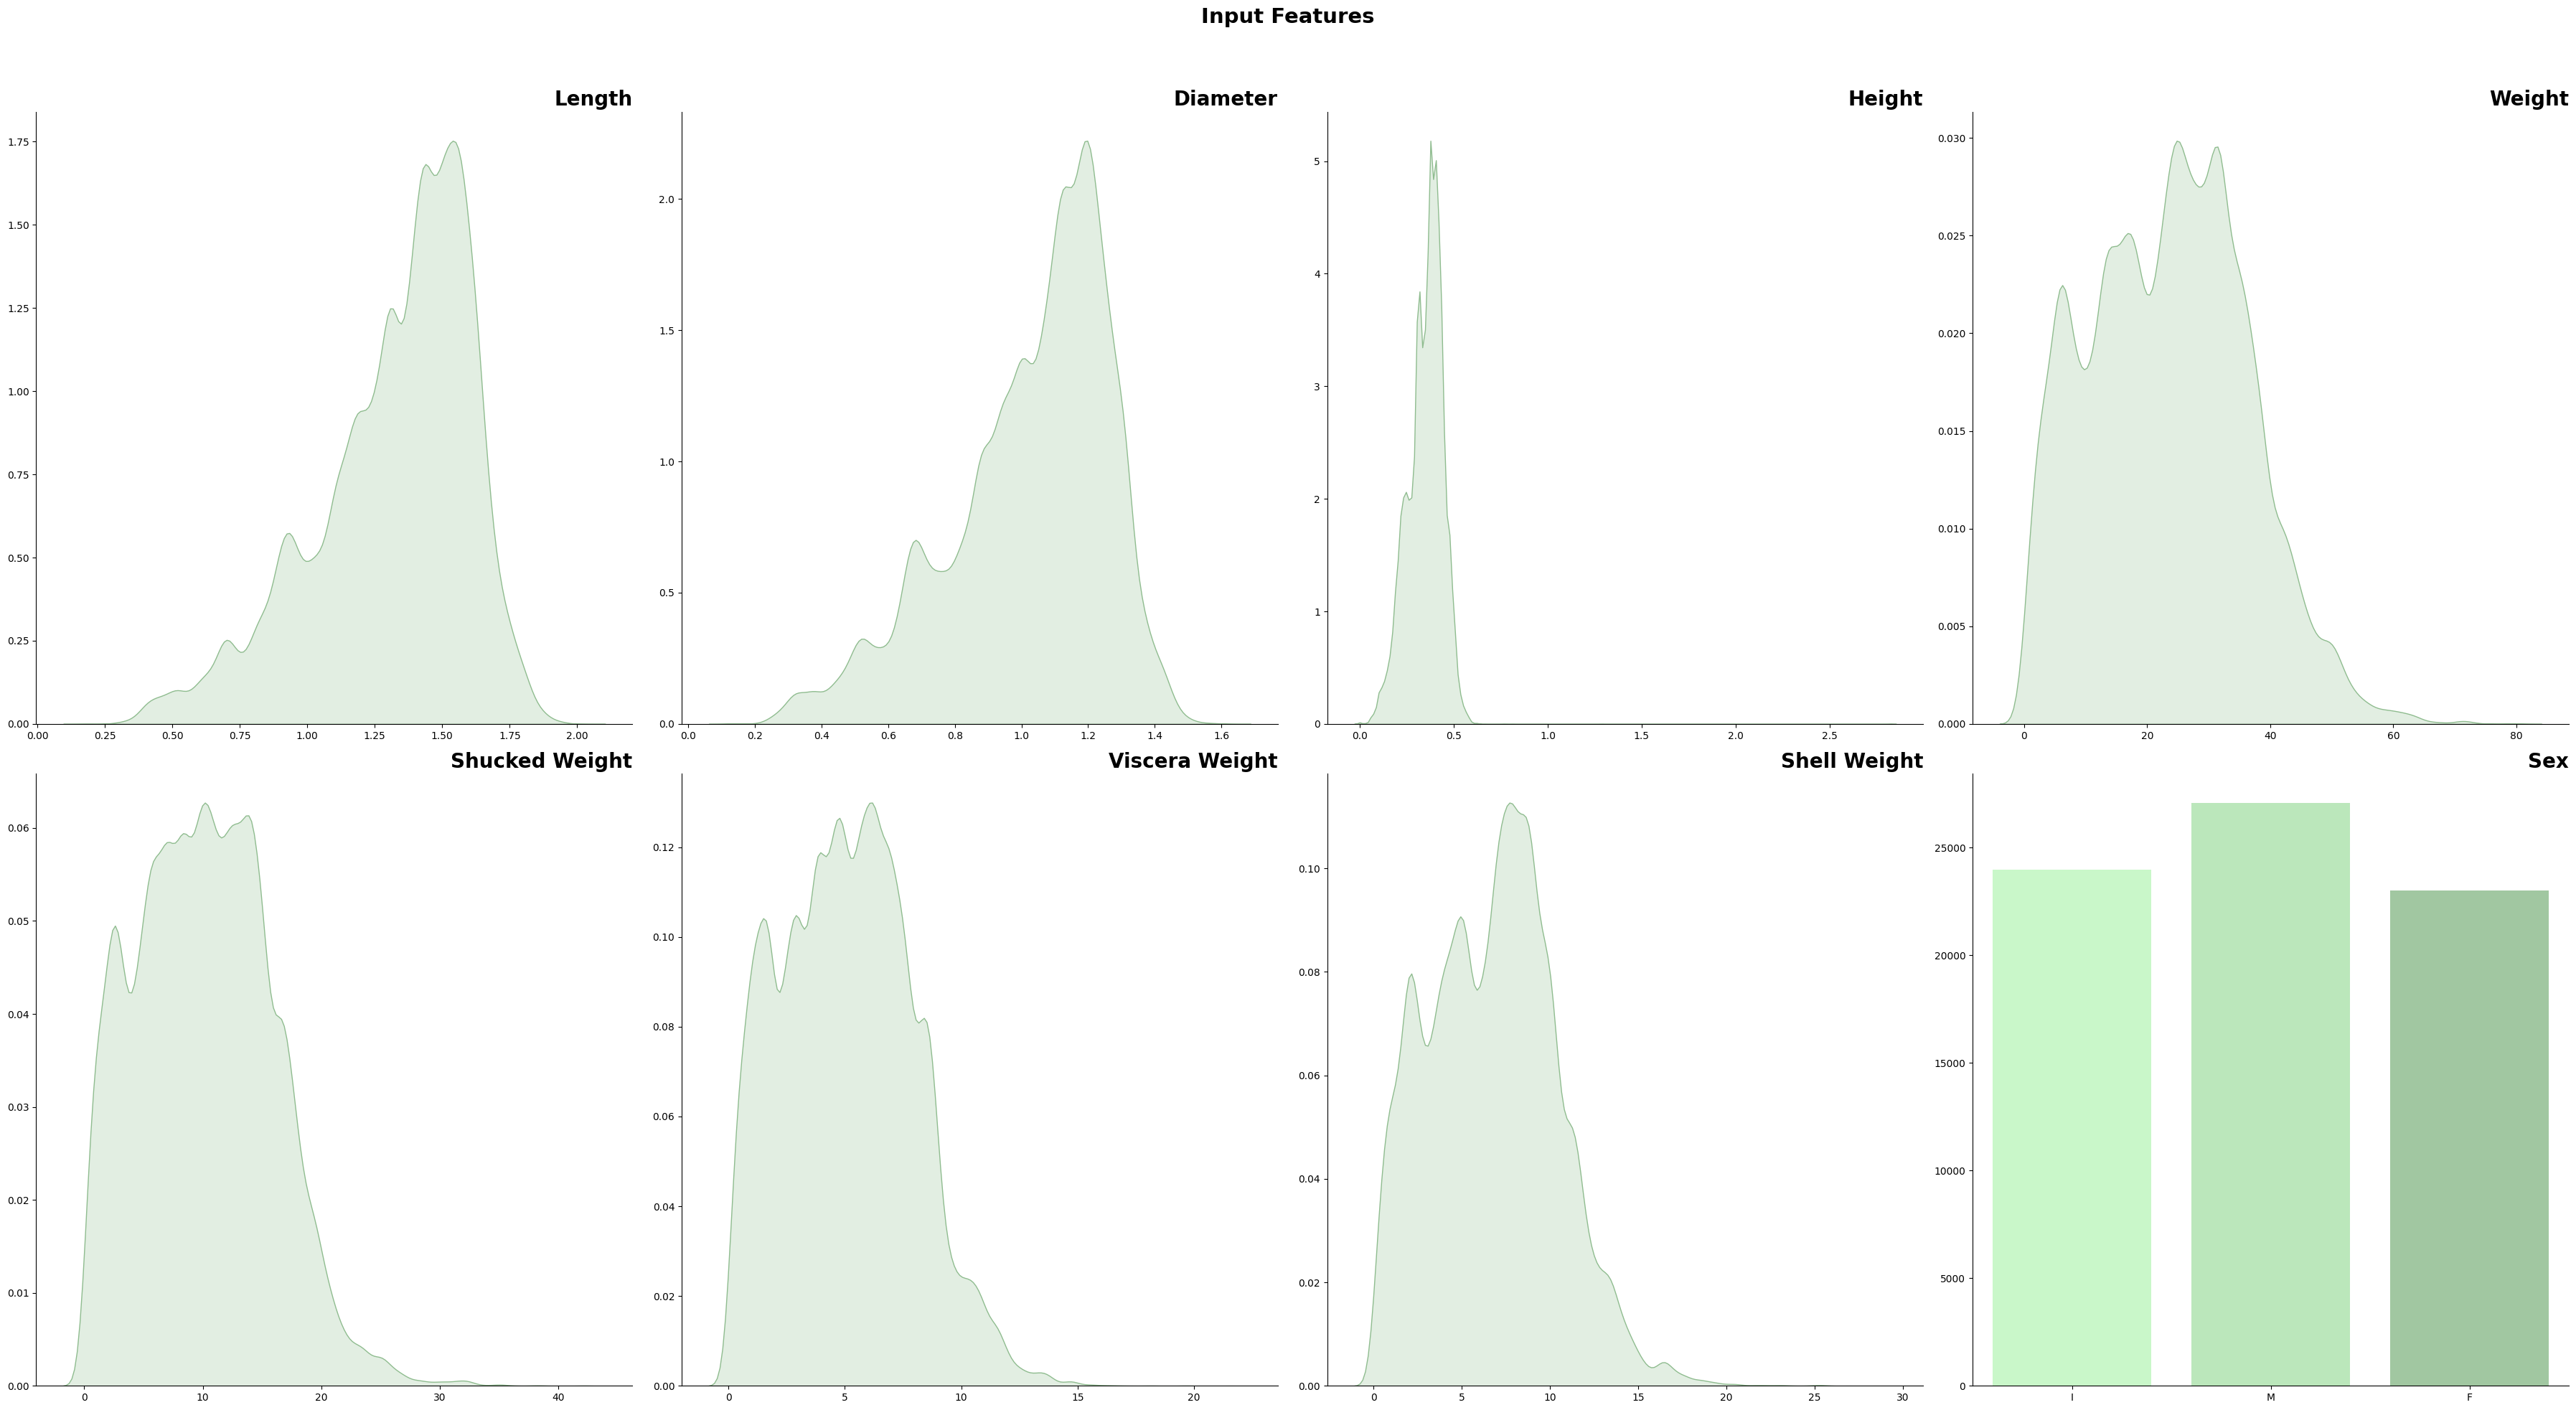

In [133]:
TARGET = "Age"
pale = ["#C1FFC1", "#B4EEB4", "#9BCD9B"]

# numerical features
figsize = (6*6, 20)
fig = plt.figure(figsize=figsize)
for idx, col in enumerate(num_cols+cat_cols):
    ax = plt.subplot(2,4, idx + 1)
    if col in cat_cols:
        sns.countplot(data=train_data, x=col, palette=pale)
    elif col in num_cols:
        sns.kdeplot(data=train_data, fill=True, x=col, legend=False, color="darkseagreen")
        
    ax.set_ylabel(''); ax.spines['top'].set_visible(False), 
    ax.set_xlabel(''); ax.spines['right'].set_visible(False)
    ax.set_title(f'{col}', loc='right', weight='bold', fontsize=20)

fig.suptitle(f'Input Features\n\n\n', ha='center',  fontweight='bold', fontsize=21)
plt.tight_layout()
plt.show()

**EXPLORATORY ANALYSIS OF TARGET FEATURE**
- We know that our target feature is age
- We will look at the corelations between age and our other variables

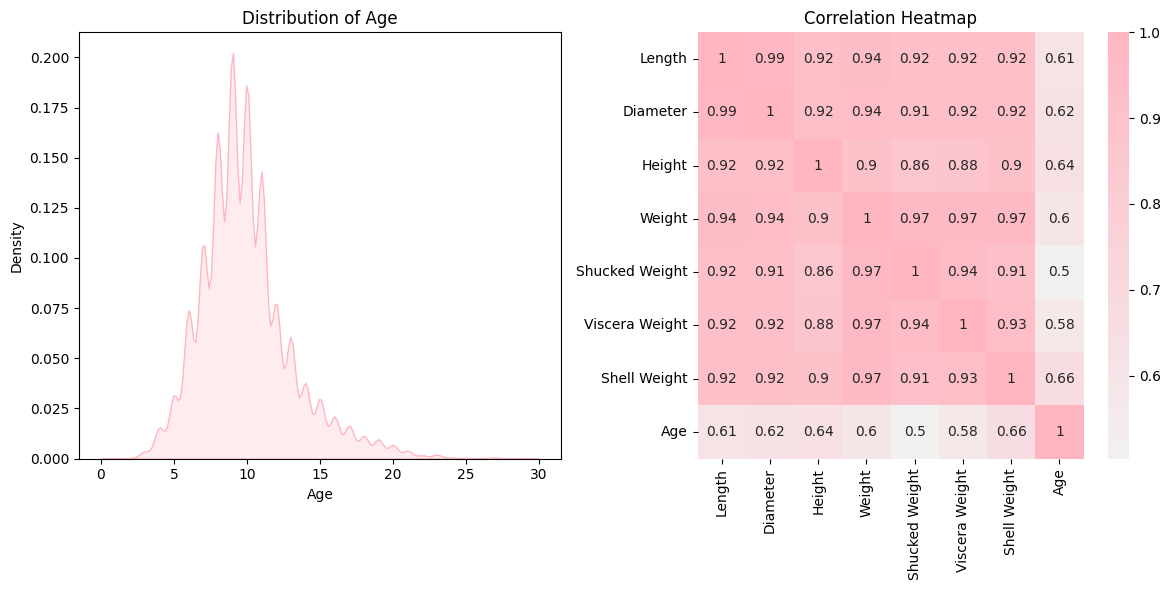

In [134]:

# Set up plot enviroment
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot a histogram with a KDE curve
sns.kdeplot(data=train_data, fill=True, x="Age", legend=False, color="lightpink", ax=axes[0])
axes[0].set_xlabel("Age")
axes[0].set_ylabel("Density")
axes[0].set_title("Distribution of Age")

# Calculate the correlation matrix
correlation_matrix = train_data.corr(numeric_only=True)
sns.heatmap(correlation_matrix, annot=True, cmap=sns.light_palette("lightpink", as_cmap=True), ax=axes[1])
axes[1].set_title('Correlation Heatmap')

# Adjust the spacing between subplots
plt.tight_layout()
# Show the plot
plt.show()

**DEALING WITH SEX**

- We will now aply one hot encoding to the sex column to make it easier to use

In [135]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_encode(df):
    # Identify categorical and numeric columns
    categorical_cols = ['Sex']
    # Separate categorical and numeric DataFrames
    categorical_df = df[categorical_cols]
    numeric_df = df.drop(categorical_cols, axis=1)

    # One-hot encode categorical data
    encoder = OneHotEncoder()
    encoded_data = encoder.fit_transform(categorical_df).toarray()
    encoded_cols = encoder.get_feature_names_out(categorical_cols)
    encoded_df = pd.DataFrame(encoded_data, columns=encoded_cols)
    
    # Concatenate numeric and encoded DataFrames
    final_df = pd.concat([numeric_df, encoded_df], axis=1)
    return final_df

train_data = one_hot_encode(train_data)
train_data.head()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,Sex_F,Sex_I,Sex_M
0,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9,0.0,1.0,0.0
1,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8,0.0,1.0,0.0
2,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9,0.0,0.0,1.0
3,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11,1.0,0.0,0.0
4,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8,0.0,1.0,0.0


**TESTING BASIC MODELS**

We will now test some basic models using k-fold cross validation such as:
- random forests
- gradient boosting

In [136]:
X = train_data.drop("Age", axis=1)
y = train_data.loc[:, "Age"]

In [143]:
# Import k fold cross validation modules
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error


k = 2  # Number of folds
kfold = KFold(n_splits=k, shuffle=True)  # Create KFold object

'''
# Test gradient boosting model
model = GradientBoostingClassifier(n_estimators=10)  
scores = cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_absolute_error')
print("Accuracy with Boositing:", scores.mean())

# Test gradient boosting model
model = RandomForestClassifier(n_estimators=10)  
scores = cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_absolute_error')
print("Accuracy with Random Forests:", scores.mean())

model.fit(X,y)
'''

Accuracy with Boositing: -1.6909698212687232
Accuracy with Random Forests: -1.6345492509907724


RandomForestClassifier(n_estimators=10)

**MLP Deep Nueral Network**

We will now try a more complex and flexable model using a ML

In [168]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import MeanAbsoluteError

# split the data into a training and hold out set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

num_epochs = 10
batch_size = 32

# Define the architecture of the MLP
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='MeanAbsoluteError')

# Train the model
model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size)

# Evaluate the model
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

model.fit(X, y, epochs=num_epochs, batch_size=batch_size)

Epoch 1/10
1620/1620 [==============================] - 4s 2ms/step - loss: 1.6329
Epoch 2/10
1620/1620 [==============================] - 3s 2ms/step - loss: 1.4733
Epoch 3/10
1620/1620 [==============================] - 3s 2ms/step - loss: 1.4483
Epoch 4/10
1620/1620 [==============================] - 3s 2ms/step - loss: 1.4436
Epoch 5/10
1620/1620 [==============================] - 3s 2ms/step - loss: 1.4413
Epoch 6/10
1620/1620 [==============================] - 3s 2ms/step - loss: 1.4335
Epoch 7/10
1620/1620 [==============================] - 3s 2ms/step - loss: 1.4293
Epoch 8/10
1620/1620 [==============================] - 3s 2ms/step - loss: 1.4254
Epoch 9/10
1620/1620 [==============================] - 3s 2ms/step - loss: 1.4201
Epoch 10/10
695/695 [==============================] - 1s 1ms/step - loss: 1.4318
Test Loss: 1.4318314790725708
Epoch 1/10
2315/2315 [==============================] - 4s 2ms/step - loss: 1.4183
Epoch 2/10
2315/2315 [==============================] - 4s

**PREDICT TEST DATA**

We will now predict the unknown test data with this model

In [169]:
X_test = process_data(test_data)
X_test = one_hot_encode(X_test)

# predict results
y_test_pred = model.predict(X_test)

# We will change the Sample Submission value
submissions = pd.read_csv(DATA_PATH + "sample_submission.csv")
submissions.loc[:, 'Age'] = y_test_pred
submissions.to_csv("submission.csv", index=False)

submissions.head()

1543/1543 [==============================] - 2s 1ms/step


,id,Age
0,74051,7.272977
1,74052,8.053043
2,74053,9.965281
3,74054,9.425483
4,74055,7.705162
